In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from rad_utils import remove_all_ticks_and_labels
from tqdm.auto import tqdm, trange
import os
import json

# also need scipy and scikit-learn

# import dataset
3D swiss roll manifold (in 10D ambient space)

note that PCA doesn't recover the original axes if the depth of the swiss roll is too large, as it is if we don't shrink the first index by 10. 

returning as tensor


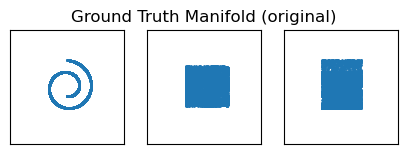

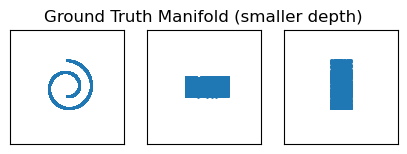

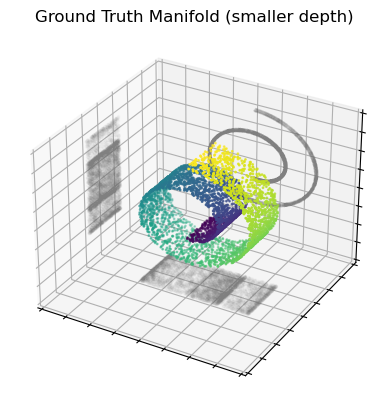

In [246]:
# import dataset
from generate_data import load_unimodal_data, load_unimodal_data_3d, load_unimodal_data_nd, make_nd_dataset
from rad_utils import generate_2d_swiss_roll

gt_manifold_t, gt_manifold, _, _ = generate_2d_swiss_roll(1e3, return_as_tensor=True)
# gt_manifold = load_unimodal_data(1e4, manifold_type='line', plot=False)
# data = load_unimodal_data_nd(1e3, 'swiss_roll_3d', 3)

data_original, _ = make_nd_dataset(int(4e3), 'swiss_roll_3d', noise=0, theta=0, return_as_tensor=False)
data, colors = make_nd_dataset(int(4e3), 'swiss_roll_3d', noise=0, shrink_y_axis=True, theta=0, return_as_tensor=False)

d0 = data[:, 0]
d1 = data[:, 1]
d2 = data[:, 2]

# --------------------------------- original --------------------------------- #
fig, ax = plt.subplots(1,3, figsize=(5,3))
# ax.scatter(*gt_manifold.T, s=1)
ax[0].scatter(*data_original[:, (0,2)].T, s=1)
ax[1].scatter(*data_original[:, (0,1)].T, s=1)
ax[2].scatter(*data_original[:, (1,2)].T, s=1)
for a in ax:
    a.set_aspect('equal')
    lims=[-3, 3]
    a.set(xlim=lims, ylim=lims)
    remove_all_ticks_and_labels(a)

ax[1].set(title='Ground Truth Manifold (original)')

# ------------------------------- smaller depth ------------------------------ #
fig, ax = plt.subplots(1,3, figsize=(5,3))
ax[0].scatter(*data[:, (0,2)].T, s=1)
ax[1].scatter(*data[:, (0,1)].T, s=1)
ax[2].scatter(*data[:, (1,2)].T, s=1)
# ax.scatter(*gt_manifold.T, s=1)
for a in ax:
    a.set_aspect('equal')
    lims=[-3, 3]
    a.set(xlim=lims, ylim=lims)
    remove_all_ticks_and_labels(a)

ax[1].set(title='Ground Truth Manifold (smaller depth)')


# --------------------- 3D view of smaller depth manifold -------------------- #
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*data[:, 0:3].T, s=1, c=colors)
# ax.set_box_aspect('equal')
# ax.view_init(40, -30, 0)
ax.set_box_aspect(None, zoom=1.0)

lims=[-2, 2]
# ax.set(xlim=lims, ylim=lims, zlim=lims)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_zlim(-2, 2)

ax.set(title='Ground Truth Manifold (smaller depth)')
remove_all_ticks_and_labels(ax, True)

dimx = d0
dimy = d1
dimz = d2

ax.scatter(dimx, dimy, color='grey', marker='.', linestyle='dashed', alpha=0.03, zdir='z', zs=-2.0)
ax.scatter(dimx, dimz, color='grey', marker='.', linestyle='dashed', alpha=0.03, zdir='y', zs=2.0)
ax.scatter(dimy, dimz, color='grey', marker='.', linestyle='dashed', alpha=0.03, zdir='x', zs=-2.0)

# find principle components using PCA

In [162]:
# perform PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
# pca.fit(data)
transformed_data = pca.fit_transform(data)
print(pca.components_.shape)
print('\n')

# --------------------------------- original --------------------------------- #
transformed_data_original = pca.fit_transform(data_original)
print(transformed_data.shape)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

print('\n')

# ------------------------------- smaller depth ------------------------------ #
print(transformed_data.shape)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)


(3, 10)


(4000, 3)
[0.39583701 0.32112431 0.28303868]
[45.28158465 40.78495722 38.29008362]


(4000, 3)
[0.39583701 0.32112431 0.28303868]
[45.28158465 40.78495722 38.29008362]


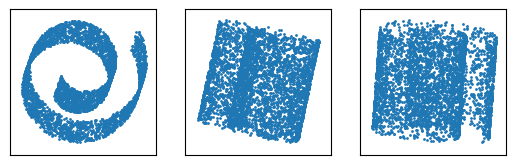

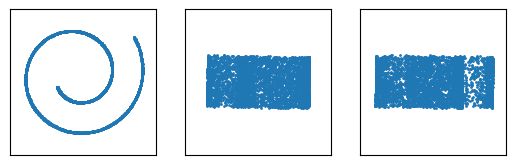

In [163]:
# --------------------------------- original --------------------------------- #
fig, ax = plt.subplots(1, 3)
ax[0].scatter(*transformed_data_original[:, 0:2].T, s=1)
ax[1].scatter(*transformed_data_original[:, 1:3].T, s=1)
ax[2].scatter(*transformed_data_original[:, (0,2)].T, s=1)

for a in ax:
    a.set_aspect('equal')
    lims=[-1.5,1.5]
    a.set(xlim=lims, ylim=lims)
    remove_all_ticks_and_labels(a)

# ------------------------------- smaller depth ------------------------------ #
fig, ax = plt.subplots(1, 3)
ax[0].scatter(*transformed_data[:, 0:2].T, s=1)
ax[1].scatter(*transformed_data[:, 1:3].T, s=1)
ax[2].scatter(*transformed_data[:, (0,2)].T, s=1)

for a in ax:
    a.set_aspect('equal')
    lims=[-1.5,1.5]
    a.set(xlim=lims, ylim=lims)
    remove_all_ticks_and_labels(a)

# finding the original axes 

we can find the original axes if we find out how the (0,0,1), (0,1,0), and (1,0,0) points were transformed by the rotation matrices

then we can project the data points onto these vectors

In [164]:
from generate_data import rotate_manifold

axes = np.zeros((1, 10))
axis_1 = axes.copy()
axis_2 = axes.copy()
axis_3 = axes.copy()

axis_1[:,0] = 1
axis_2[:,1] = 1
axis_3[:,2] = 1

theta = np.pi/4
n_dims = 10

# for every axis pair, rotate the vector by angle theta
def rotate_point(z):
    for i in range(0, n_dims-1):
        for j in range(i+1, n_dims):
            z = rotate_manifold(z, n_dims, i, j, theta)
    return z

rotated_pt_1 = rotate_point(axis_1)
rotated_pt_2 = rotate_point(axis_2)
rotated_pt_3 = rotate_point(axis_3)

print(rotated_pt_1)
print(rotated_pt_2)
print(rotated_pt_3)

# sanity check: these dots should be orthogonal
print(np.dot(rotated_pt_1, rotated_pt_2.T))
print(np.dot(rotated_pt_2, rotated_pt_3.T))
print(np.dot(rotated_pt_3, rotated_pt_1.T))


[[ 0.04419417 -0.20580583  0.320733   -0.10068204 -0.09943689  0.02556311
   0.10038471  0.16422512  0.34123179  0.82380642]]
[[-0.04419417  0.29419417 -0.66984465  0.539483    0.06504611 -0.13068689
  -0.05730097  0.06132221  0.16422512  0.34123179]]
[[-0.0625      0.26516504 -0.17455583 -0.55935922  0.711358    0.09819174
  -0.16974939 -0.08492233  0.06132221  0.16422512]]
[[1.27362377e-16]]
[[-7.37261547e-17]]
[[9.0471951e-18]]


# train model on new dataset

In [165]:
# training process
from utils import forward_process, noise_estimation_loss
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import time

def reverse_process(model, 
                    model_name, 
                    model_number, 
                    num_steps, 
                    num_hidden, 
                    num_dims,
                    num_epochs,
                    batch_size,
                    lr,
                    device,
                    dataset,
                    pretrained_model):
    
    # beta-related parameters
    coefs = forward_process(num_steps, device)
    betas, alphas, alphas_prod, alphas_prod_p, alphas_bar_sqrt, one_minus_alphas_prod_log, one_minus_alphas_prod_sqrt = coefs
    alphas_bar_sqrt = alphas_bar_sqrt.to(device)
    one_minus_alphas_prod_sqrt = one_minus_alphas_prod_sqrt.to(device)
    
    # training set
    dataset = dataset.to(device)
    
    # define model
    if pretrained_model['use_pretrained_model_weights']:
        from utils import load_model_weights
        pretrained_model_name = pretrained_model['model_name']
        pretrained_model_num = pretrained_model['model_num']
        print(f'taking weights from pretrained model {pretrained_model_name}_{pretrained_model_num}!')
        model = load_model_weights(model, pretrained_model_name, pretrained_model_num, device)
    model.to(device)

    # training parameteres
    optimizer = optim.Adam(model.parameters(), lr=lr)

    tb = SummaryWriter(f'runs/{model_name}_{model_number}')
    start_time = time.time()
    
    # start training
    model.train()
    for t in trange(int(num_epochs), desc='Training model', unit='epochs'):
        permutation = torch.randperm(dataset.size()[0], device=device)
    
        for i in range(0, dataset.size()[0], batch_size):
            # retrieve current batch
            indices = permutation[i:i+batch_size]
            batch_x = dataset[indices]
            
            # compute the loss
            loss = noise_estimation_loss(model, batch_x, num_steps, alphas_bar_sqrt, one_minus_alphas_prod_sqrt, device, norm='l2', has_class_label=False)
            # zero the gradients
            optimizer.zero_grad()
            # backward pass: compute the gradient of the loss wrt the parameters
            loss.backward()
            # call the step function to update the parameters
            optimizer.step()
        
        # write to tensorboard
        tb.add_scalar('Loss', loss.item(), t)

        # print loss
        if (t % (num_epochs/10) == 0):
            print('t', t)
            print('loss', loss.item())
    tb.flush()

    end_time = time.time()
    duration = end_time - start_time
    duration_mins = duration / 60
    print(f'training took {duration:.0f} seconds, which is {duration_mins:.2f} minutes.')
    return model



In [254]:
# define hyperparameter values
global device
device = torch.device('cpu')
print(device)

# -------------------------- set model parameters -------------------------- #
# model_name = 'single_layer_network'
model_name = 'unconditional-dendritic-3d-manifold'
model_number = 11
num_steps = 100
num_hidden = [3, 3, 3, 3, 3, 3, 4]
num_ambient_dims = 10
num_manifold_dims = 3
num_samples_in_training_set = 1e3
epochs = 5e4
manifold_type = 'swiss_roll_3d'
manifold_rotation_angle = np.pi/4
batch_size = 128
lr = 3e-4
pretrained_model = {
    'use_pretrained_model_weights': True,
    'model_name': 'unconditional-dendritic-3d-manifold',
    'model_num': 10
}

# -------------------------- save model description -------------------------- #
description = {
    'model_name': model_name,
    'model_number': model_number,
    'num_steps': num_steps,
    'num_hidden': num_hidden,
    'num_ambient_dims': num_ambient_dims,
    'num_manifold_dims': num_manifold_dims,
    'num_samples_in_training_set': f'{num_samples_in_training_set:.0e}',
    'num_epochs': f'{epochs:.0e}',
    'manifold_type': manifold_type,
    'manifold_rotation_angle': manifold_rotation_angle,
    'batch_size': batch_size,
    'learning_rate': f'{lr:.0e}',
    'use_pretrained_model': pretrained_model['use_pretrained_model_weights'],
}
if pretrained_model['use_pretrained_model_weights']:
    description['pretrained_model_name'] = pretrained_model['model_name']
    description['pretrained_model_num'] = pretrained_model['model_num']

json_savedir = 'model_description'
model_name_and_number = f'{model_name}_{model_number}'
json_name = f'{model_name_and_number}.json'
with open(os.path.join(json_savedir, json_name), 'w') as file:
    json.dump(description, file)


# -------------------------------- load model -------------------------------- #
from models import VariableDendriticCircuit
model = VariableDendriticCircuit(hidden_cfg=num_hidden, num_in=num_ambient_dims, num_out=num_ambient_dims, bias=True)

# ------------------------------- load dataset ------------------------------- #
from utils import rescale_samples_to_pm1
from generate_data import load_unimodal_data, load_unimodal_data_3d, load_unimodal_data_nd, make_nd_dataset
# dataset, _ = make_nd_dataset(int(num_samples_in_training_set), 'swiss_roll_3d', noise=0, shrink_y_axis=True, return_as_tensor=True)
# dataset = rescale_samples_to_pm1(dataset)
# print(dataset.shape[0])
# print(type(dataset))

# -------------------- TRAINING - reverse diffusion process ------------------ #
model = reverse_process(model, model_name, model_number, num_steps, num_hidden, num_ambient_dims, epochs, batch_size, lr, device, dataset, pretrained_model)
from utils import save_model_weights
save_model_weights(model, model_name, model_number)

cpu
taking weights from pretrained model unconditional-dendritic-3d-manifold_10!
model loaded!


Training model:   0%|          | 0/50000 [00:00<?, ?epochs/s]

t 0
loss 0.3813144564628601
t 5000
loss 0.24170368909835815
t 10000
loss 0.22581134736537933
t 15000
loss 0.23343190550804138
t 20000
loss 0.2275938093662262
t 25000
loss 0.28195920586586
t 30000
loss 0.23263052105903625
t 35000
loss 0.25762003660202026
t 40000
loss 0.23201411962509155
t 45000
loss 0.25012752413749695
training took 5175 seconds, which is 86.25 minutes.
model state dict saved in directory: ./saved_weights/


# test

In [255]:
from generate_data import p_sample_loop, p_sample_loop_new, p_sample_loop_snn
from utils import forward_process, load_model_weights, rescale_samples_to_pm1
from models import NoiseConditionalEstimatorConcat

sample_size = 5e2
lims = [-3,3]

num_hidden = [3, 3, 3, 3, 3, 3, 4]
model = VariableDendriticCircuit(hidden_cfg=num_hidden, num_in=num_ambient_dims, num_out=num_ambient_dims, bias=True)
model = load_model_weights(model, 'unconditional-dendritic-3d-manifold', 11, device)


x_seq = p_sample_loop_new(model, (int(sample_size), num_ambient_dims), num_steps, device)  # with sampling noise
# x_seq = p_sample_loop_snn(model, (int(sample_size), num_ambient_dims), num_steps, device)  # withouth sampling noise

model loaded!


0.7853981633974483


[Text(0.5, 1.0, 'ground truth')]

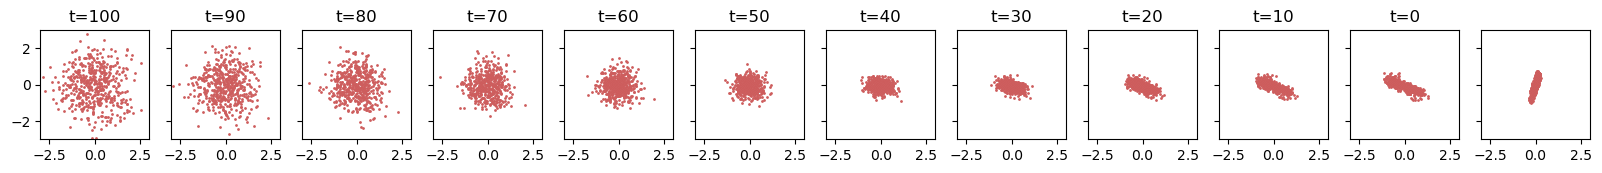

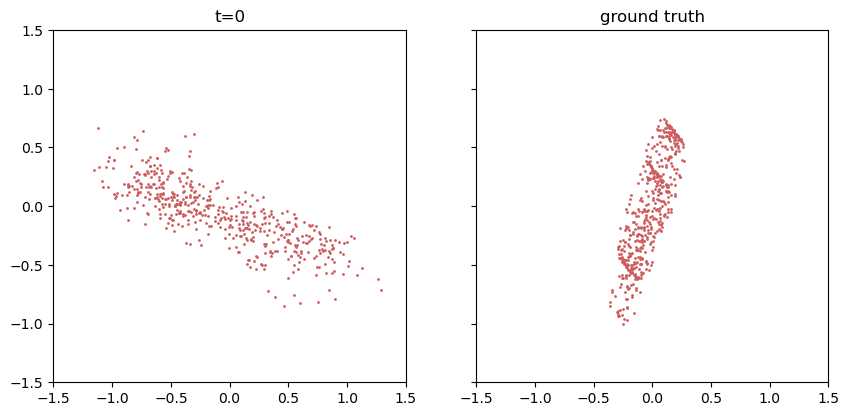

In [265]:
dim0 = 2
dim1 = 5


fig, axes = plt.subplots(1, 12, figsize=(20, 3), sharey=True)
for i in range(0, 11):
    cur_x = x_seq[i * 10].detach().cpu()
    ax = axes[i]
    ax.scatter(cur_x[:, dim0], cur_x[:, dim1],color='white',edgecolor='indianred', s=1);
    ax.set_aspect('equal')
    ax.set(xlim=lims, ylim=lims)
    # remove_all_ticks_and_labels(ax)
    ax.set(title=f't={100-i*10}')
    
# comparison against ground truth
print(manifold_rotation_angle)
test_dataset, _ = make_nd_dataset(int(sample_size), 'swiss_roll_3d', noise=0, theta=manifold_rotation_angle, shrink_y_axis=True, return_as_tensor=True)
test_dataset = rescale_samples_to_pm1(test_dataset)


ax = axes[11]
ax.scatter(test_dataset[:, dim0], test_dataset[:, dim1],color='white',edgecolor='indianred', s=1)
ax.set_aspect('equal')
ax.set(xlim=lims, ylim=lims)
# remove_all_ticks_and_labels(ax)

# show the last plot in more detail, and compare it against ground truth
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
ax = axes[0]
ax.scatter(cur_x[:, dim0], cur_x[:, dim1],color='white',edgecolor='indianred', s=1);
ax.set_aspect('equal')
lims2 = [-1.5, 1.5]
ax.set(xlim=lims2, ylim=lims2)
# remove_all_ticks_and_labels(ax)
ax.set(title=f't={100-i*10}')

ax = axes[1]
ax.scatter(test_dataset[:, dim0], test_dataset[:, dim1],color='white',edgecolor='indianred', s=1)
ax.set_aspect('equal')
ax.set(xlim=lims2, ylim=lims2)
ax.set(title=f'ground truth')

In [191]:
# model details

pytorch_total_params = sum(p.numel() for p in model.parameters())
print("Total number of parameters: ", pytorch_total_params)

Total number of parameters:  408210
